In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys # used in command to make entire array print by default
import seaborn as sns

# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

In [2]:
def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict




def linreg(X_train, y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train.recovery, y = y_pred.ravel())
    reg_df = pd.DataFrame(lr.coef_, columns=X_vars)
    reg_df = reg_df.transpose().sort_values(by=0, ascending=False)
    reg_df.rename(index=str, columns={0: 'value'}, inplace=True)
    abs_df = reg_df.copy()
    abs_df['value'] = abs(abs_df['value'])
    abs_df.sort_values(by='value', ascending=False)
    return reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter

def ridge(X_train, y_train):
    rr = Ridge(alpha=.5)
    rr.fit(X_train, y_train)
    y_pred = rr.predict((X_train))
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train, y = y_pred.ravel())
    return rr, rr.coef_, rr.intercept_, MAE, MSE, y_pred, scatter

def svm(X_train, y_train):
    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    svr_lin = SVR(kernel='linear', C=100, gamma='auto')
    svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)
    y_rbf = svr_rbf.fit(X_train, y_train).predict(X_train)
    y_lin = svr_lin.fit(X_train, y_train).predict(X_train)
    y_poly = svr_poly.fit(X_train, y_train).predict(X_train)
    MSE_rbf = mean_squared_error(y_train, y_rbf)
    MSE_lin = mean_squared_error(y_train, y_lin)
    MSE_poly = mean_squared_error(y_train, y_poly)
    return svr_rbf, svr_lin, svr_poly, MSE_rbf, MSE_lin, MSE_poly, y_rbf, y_lin, y_poly

In [3]:
df = acquire_oil()
df = prep_data(df)
df.reset_index(inplace=True)
df.shape

(7888, 39)

In [4]:
df.isnull().sum()

index                 0
api14                 0
lease_name            0
well_number           0
county                0
direction             0
status                0
oper                  0
multi_well_lease      0
major_phase           0
formation             0
proppant_ppf          0
prod_method           0
frac_fluid_gpf        0
gross_perfs           0
frac_stages           0
frac_fluid_type       0
first_prod            0
last_prod             0
oil_gravity           0
peak_boepd            0
oil_hist              0
gas_hist              0
gor_hist              0
ip90_boeqpd           0
tvd                   0
sur_lat               0
sur_long              0
well_id               0
mid_point_lat         0
mid_point_long        0
sub-basin             0
recovery              0
recovery_per_foot     0
months_active         0
recovery_per_month    0
lateral_class         0
vintage               0
vintage_bin           0
dtype: int64

In [22]:
df.drop(columns=['api14', 'sur_lat', 'sur_long', 'well_id', 'mid_point_lat', 
                 'mid_point_long', 'tvd']).describe()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,ip90_boeqpd,recovery,recovery_per_foot,months_active,recovery_per_month,vintage,vintage_bin
count,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000
mean,1129.177020,1142.213462,5732.858773,3.204488,1.862447,508.725133,120.070635,385.288562,3888.944514,349.246186,152.154977,36.226277,60.276242,inf,2011.733266,4.485548
std,656.539972,714.303891,2945.296014,9.336062,9.188722,443.645469,95.660116,387.207769,3815.982884,315.135247,140.362192,61.383543,60.115080,NaN,8.202743,0.780967
min,1.098097,0.354610,4.000000,0.000000,0.000000,0.663017,0.031000,0.001000,0.212134,0.001812,0.013000,0.002991,0.000000,0.590909,1958.000000,1.000000
25%,525.892109,499.423181,4056.250000,0.000000,0.000000,159.810463,46.481500,110.739000,1422.937793,94.906605,57.693208,14.000433,32.000000,1071.903909,2012.000000,4.000000
50%,1156.356260,1222.371400,6242.000000,0.000000,0.000000,429.084519,101.236000,284.305000,2491.502805,292.328796,125.145754,22.247945,49.000000,2688.833781,2014.000000,5.000000
75%,1594.793975,1653.074860,7723.250000,0.000000,0.000000,732.588900,172.310750,542.369000,4906.603828,508.700090,196.330132,36.956724,66.000000,4944.219785,2015.000000,5.000000
max,3969.384520,2997.879640,13581.000000,70.000000,68.000000,6118.757000,754.662000,4007.768000,19968.130000,4752.926000,999.305470,997.824074,726.000000,inf,2018.000000,5.000000


## Standardize Numeric Data

In [23]:
numerics = ['int64', 'float64']

num_df = df.select_dtypes(include=numerics)
num_df = num_df.drop(columns=['gas_hist', 'recovery_per_foot', 
                              'recovery_per_month', 'api14',
#                              'landing_depth', sur_long', 'sur_lat', 'mid_point_lat', 'mid_point_long',
                             'well_id', 'oil_hist'])

### Use LabelEncoder to encode county, frac_fluid_type, oper, type, and formation.

In [24]:
df.select_dtypes(exclude=numerics).columns

Index(['index', 'lease_name', 'well_number', 'county', 'direction', 'status',
       'oper', 'multi_well_lease', 'major_phase', 'formation', 'prod_method',
       'frac_fluid_type', 'first_prod', 'last_prod', 'sub-basin',
       'lateral_class'],
      dtype='object')

In [25]:
# Not encoding: 'index', 'lease_name', 'well_number', 'status',
#               'multi_well_lease', 'major_phase', 'prod_method',
#               'first_prod', 'last_prod'

for col in ['county', 'direction', 'oper', 'formation', 'frac_fluid_type', 
            'sub-basin', 'lateral_class']:
    encoder = LabelEncoder()
    encoder.fit(df[col])
    num_df[col] = encoder.transform(df[col])
num_df.head()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,sur_lat,...,months_active,vintage,vintage_bin,county,direction,oper,formation,frac_fluid_type,sub-basin,lateral_class
0,1311.78809,1642.58887,3977.0,0.0,0.0,61.408554,1738.53259,47.452900,10021.0,32.434761,...,33,2016,5,0,0,66,29,7,2,3
1,1088.56238,1493.36900,7283.0,0.0,0.0,416.961182,1381.57100,351.796700,9764.0,32.124361,...,66,2013,4,0,0,52,29,3,2,0
2,951.97060,1369.34363,7382.0,0.0,0.0,838.371765,1961.41300,688.525400,10798.0,32.351297,...,64,2013,4,0,0,166,29,0,2,0
3,1155.36267,1299.68433,7382.0,31.0,0.0,438.325684,1325.53870,406.427765,9506.0,32.345441,...,63,2013,4,0,0,166,29,3,2,0
4,1284.25537,1596.72742,7050.0,0.0,0.0,443.969543,2816.79077,289.934052,10138.0,32.293814,...,59,2014,5,0,0,52,29,7,2,0


In [26]:
num_df[['county']].describe()

,county
count,7888.000000
mean,19.474011
std,9.319448
min,0.000000
25%,13.000000
50%,22.000000
75%,26.000000
max,37.000000


In [27]:
num_df[['county']].sample(5)

,county
5476,34
1743,15
5291,30
6490,5
4404,26


## Scale the data:

In [28]:
scaled_df = num_df.copy()
scaled_df['proppant_ppf'] = (scaled_df.proppant_ppf - scaled_df.proppant_ppf.min()) / (scaled_df.proppant_ppf.max() - scaled_df.proppant_ppf.min())
scaled_df['frac_fluid_gpf'] = (scaled_df.frac_fluid_gpf - scaled_df.frac_fluid_gpf.min()) / (scaled_df.frac_fluid_gpf.max() - scaled_df.frac_fluid_gpf.min())
scaled_df['gross_perfs'] = (scaled_df.gross_perfs - scaled_df.gross_perfs.min()) / (scaled_df.gross_perfs.max() - scaled_df.gross_perfs.min())
scaled_df['frac_stages'] = (scaled_df.frac_stages - scaled_df.frac_stages.min()) / (scaled_df.frac_stages.max() - scaled_df.frac_stages.min())
scaled_df['oil_gravity'] = (scaled_df.oil_gravity - scaled_df.oil_gravity.min()) / (scaled_df.oil_gravity.max() - scaled_df.oil_gravity.min())
scaled_df['peak_boepd'] = (scaled_df.peak_boepd - scaled_df.peak_boepd.min()) / (scaled_df.peak_boepd.max() - scaled_df.peak_boepd.min())
scaled_df['gor_hist'] = (scaled_df.gor_hist - scaled_df.gor_hist.min()) / (scaled_df.gor_hist.max() - scaled_df.gor_hist.min())
scaled_df['ip90_boeqpd'] = (scaled_df.ip90_boeqpd - scaled_df.ip90_boeqpd.min()) / (scaled_df.ip90_boeqpd.max() - scaled_df.ip90_boeqpd.min())
scaled_df['months_active'] = (scaled_df.months_active - scaled_df.months_active.min()) / (scaled_df.months_active.max() - scaled_df.months_active.min())
scaled_df['vintage'] = (scaled_df.vintage - scaled_df.vintage.min()) / (scaled_df.vintage.max() - scaled_df.vintage.min())
scaled_df['county'] = (scaled_df.county - scaled_df.county.min()) / (scaled_df.county.max() - scaled_df.county.min())
scaled_df['frac_fluid_type'] = (scaled_df.frac_fluid_type - scaled_df.frac_fluid_type.min()) / (scaled_df.frac_fluid_type.max() - scaled_df.frac_fluid_type.min())
scaled_df['oper'] = (scaled_df.oper - scaled_df.oper.min()) / (scaled_df.oper.max() - scaled_df.oper.min())
scaled_df['direction'] = (scaled_df.direction - scaled_df.direction.min()) / (scaled_df.direction.max() - scaled_df.direction.min())
scaled_df['formation'] = (scaled_df.formation - scaled_df.formation.min()) / (scaled_df.formation.max() - scaled_df.formation.min())
scaled_df['tvd'] = (scaled_df.tvd - scaled_df.tvd.min()) / (scaled_df.tvd.max() - scaled_df.tvd.min())
scaled_df['sur_lat'] = (scaled_df.sur_lat - scaled_df.sur_lat.min()) / (scaled_df.sur_lat.max() - scaled_df.sur_lat.min())
scaled_df['sur_long'] = (scaled_df.sur_long - scaled_df.sur_long.min()) / (scaled_df.sur_long.max() - scaled_df.sur_long.min())
scaled_df['mid_point_lat'] = (scaled_df.mid_point_lat - scaled_df.mid_point_lat.min()) / (scaled_df.mid_point_lat.max() - scaled_df.mid_point_lat.min())
scaled_df['mid_point_long'] = (scaled_df.mid_point_long - scaled_df.mid_point_long.min()) / (scaled_df.mid_point_long.max() - scaled_df.mid_point_long.min())
scaled_df['sub-basin'] = (scaled_df['sub-basin'] - scaled_df['sub-basin'].min()) / (scaled_df['sub-basin'].max() - scaled_df['sub-basin'].min())
scaled_df['lateral_class'] = (scaled_df.lateral_class - scaled_df.lateral_class.min()) / (scaled_df.lateral_class.max() - scaled_df.lateral_class.min())

scaled_df['recovery'] = (scaled_df.recovery - scaled_df.recovery.min()) / (scaled_df.recovery.max() - scaled_df.recovery.min())
scaled_df.rename(index=str, columns={"oper": "operator"}, inplace=True)

In [29]:
scaled_df.sample(10)

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,sur_lat,...,months_active,vintage,vintage_bin,county,direction,operator,formation,frac_fluid_type,sub-basin,lateral_class
6294,0.150648,0.370387,0.338882,0.000000,0.0,0.050092,0.165942,0.046827,0.528510,0.550044,...,0.070248,0.933333,5,0.000000,0.0,0.011364,0.736842,0.375,0.0,0.153846
2861,0.330682,0.588096,0.751197,0.000000,0.0,0.145833,0.055819,0.116731,0.657809,0.597297,...,0.041322,0.966667,5,0.594595,0.0,0.996212,0.763158,0.375,1.0,0.076923
3100,0.165487,0.152984,0.012079,0.000000,0.0,0.001645,0.066030,0.001491,0.000000,0.461082,...,0.283747,0.683333,3,0.621622,1.0,0.628788,0.631579,0.250,1.0,0.461538
3160,0.050562,0.174109,0.054651,0.000000,0.0,0.020817,0.069586,0.019988,0.000000,0.380730,...,0.090909,0.716667,4,0.621622,1.0,0.257576,0.763158,0.375,1.0,0.461538
1440,0.070598,0.046795,0.009133,0.000000,0.0,0.001853,0.000197,0.001872,0.000000,0.509307,...,0.048209,0.900000,4,0.405405,1.0,0.181818,0.552632,0.000,1.0,0.461538
6744,0.085776,0.125990,0.348383,0.142857,0.0,0.040102,0.011627,0.049060,0.340256,0.646527,...,0.055096,0.950000,5,0.297297,0.0,0.284091,0.552632,0.375,0.0,0.153846
2308,0.232548,0.331592,0.329233,0.000000,0.0,0.022643,0.287656,0.014982,0.496353,0.212441,...,0.070248,0.933333,5,0.432432,0.0,0.738636,0.763158,0.875,1.0,0.153846
943,0.035453,0.084290,0.332916,0.000000,0.0,0.145767,0.169508,0.139753,0.573917,0.388204,...,0.060606,0.933333,5,0.351351,0.0,0.250000,0.763158,0.875,1.0,0.153846
4511,0.328984,0.429514,0.524195,0.000000,0.0,0.052765,0.057724,0.059712,0.579798,0.228247,...,0.081267,0.933333,5,0.702703,0.0,0.314394,0.763158,0.375,1.0,0.000000
5920,0.426570,0.805127,0.720483,0.000000,0.0,0.359387,0.105424,0.367880,0.697261,0.306495,...,0.031680,0.966667,5,0.918919,0.0,0.196970,0.763158,0.875,1.0,0.692308


## Visualize Data

### Attribute Histograms

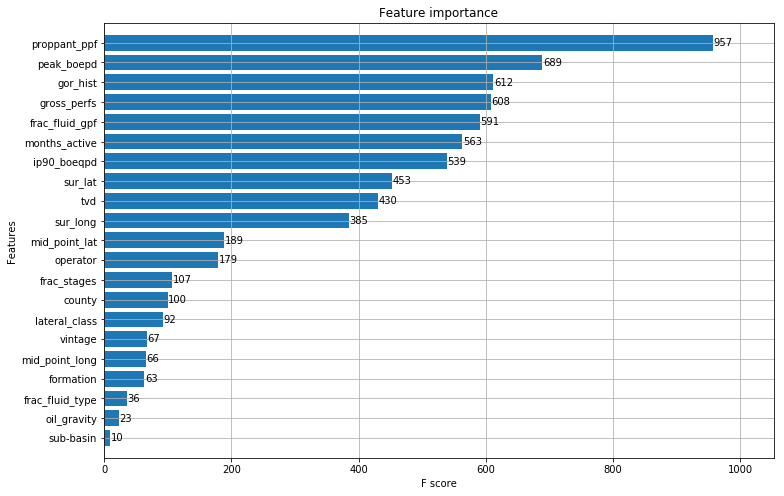

In [30]:
xgb_df = scaled_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# I think we can return xgb and model to then plot xgb.plot_importance(model,...)
# Or maybe can save that line into a variable to return.

## Test Harness and Options

#### Run the regression with all of the features:

In [31]:
scaled_df.columns

Index(['proppant_ppf', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gor_hist', 'ip90_boeqpd', 'tvd',
       'sur_lat', 'sur_long', 'mid_point_lat', 'mid_point_long', 'recovery',
       'months_active', 'vintage', 'vintage_bin', 'county', 'direction',
       'operator', 'formation', 'frac_fluid_type', 'sub-basin',
       'lateral_class'],
      dtype='object')

MAE: 0.034218846604866585
MSE: 0.009157954796939424
lr.intercept: -0.03689640016178264


,value
mid_point_long,5.276279
mid_point_lat,1.358729
peak_boepd,0.824708
ip90_boeqpd,0.556295
months_active,0.264288
oil_gravity,0.110661
tvd,0.055826
gross_perfs,0.051327
gor_hist,0.043472
formation,0.039781


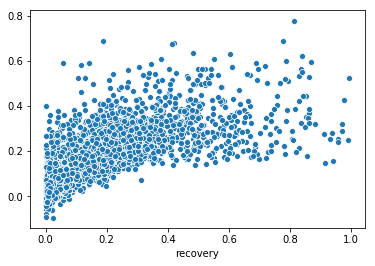

In [32]:
# Independent variables:
X_vars = ['proppant_ppf', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gor_hist', 'ip90_boeqpd', 'tvd',
       'sur_lat', 'sur_long', 'mid_point_lat', 'mid_point_long', 
       'months_active', 'vintage', 'vintage_bin', 'county', 'direction',
       'operator', 'formation', 'frac_fluid_type', 'sub-basin',
       'lateral_class']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [33]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
sur_long,5.282061
mid_point_long,5.276279
mid_point_lat,1.358729
sur_lat,1.342904
peak_boepd,0.824708
ip90_boeqpd,0.556295
months_active,0.264288
oil_gravity,0.110661
proppant_ppf,0.082324
tvd,0.055826


Copied xgboost chart for easy comparison.

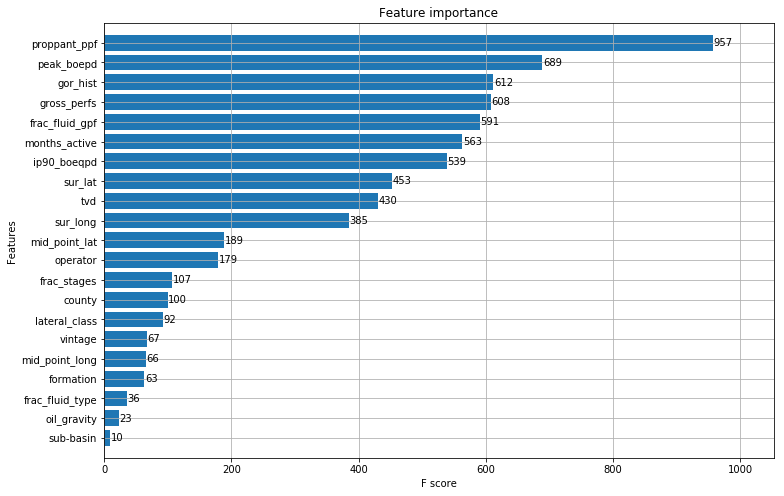

#### Filter all features for only vertical wells:

MAE: 0.009409456805546933
MSE: 0.0006284623656151205
lr.intercept: -0.005217606005861845


,value
mid_point_lat,2.329714e+01
sur_long,1.371619e+01
peak_boepd,1.137363e+00
ip90_boeqpd,7.189896e-01
gross_perfs,1.676534e-01
months_active,1.333834e-01
gor_hist,2.457099e-02
tvd,1.659581e-02
frac_fluid_gpf,1.439387e-02
sub-basin,7.776672e-03


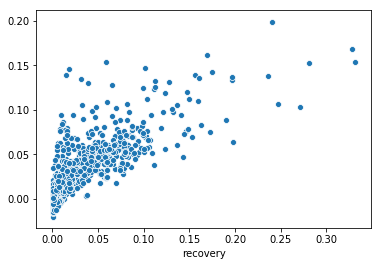

In [34]:
# Independent variables:
X_vars = ['proppant_ppf', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gor_hist', 'ip90_boeqpd', 'tvd',
       'sur_lat', 'sur_long', 'mid_point_lat', 'mid_point_long', 
       'months_active', 'vintage', 'vintage_bin', 'county', 'direction',
       'operator', 'formation', 'frac_fluid_type', 'sub-basin',
       'lateral_class']

# Dependent (target) variable, it is continuous
target = ['recovery']

# These lines are to filter for only vertical wells:
df_vert = scaled_df[scaled_df.direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [35]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
sur_lat,2.330624e+01
mid_point_lat,2.329714e+01
mid_point_long,1.373775e+01
sur_long,1.371619e+01
peak_boepd,1.137363e+00
ip90_boeqpd,7.189896e-01
frac_stages,2.683470e-01
gross_perfs,1.676534e-01
months_active,1.333834e-01
gor_hist,2.457099e-02


#### Test only top features suggested by XGBoost (exclude peak_boepd), without filtering for vertical wells.

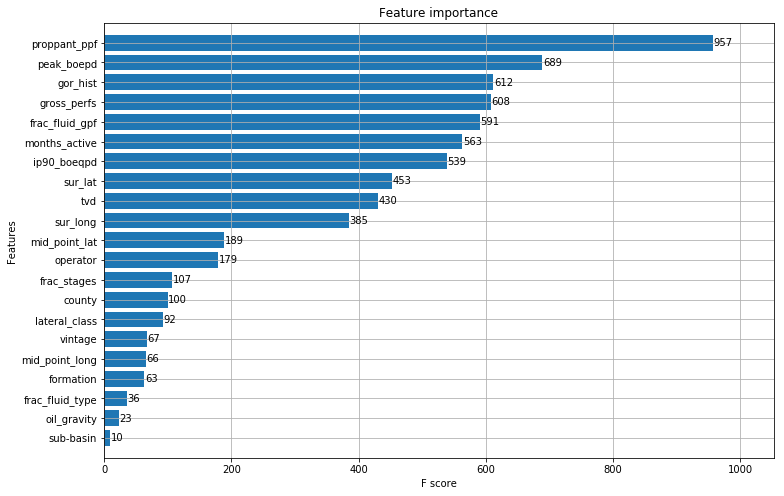

MAE: 0.0363753688415603
MSE: 0.010072701979923873
lr.intercept: -0.015606097318500073
reg_df:


,value
ip90_boeqpd,1.244191
months_active,0.271153
gross_perfs,0.078935
gor_hist,0.078117
tvd,0.064716
sur_lat,0.039942
frac_fluid_gpf,-0.006075
proppant_ppf,-0.025648
sur_long,-0.053581


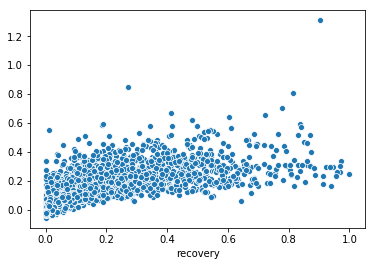

In [36]:
# Independent variables:
# X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
#           'months_active', 'lateral_len', 'ip90_boeqpd', 'county']
X_vars = ['proppant_ppf', 'gor_hist', 'gross_perfs', 'frac_fluid_gpf', 
          'months_active', 'ip90_boeqpd', 'sur_lat', 'tvd', 'sur_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
print('reg_df:')
reg_df

In [37]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
ip90_boeqpd,1.244191
months_active,0.271153
gross_perfs,0.078935
gor_hist,0.078117
tvd,0.064716
sur_long,0.053581
sur_lat,0.039942
proppant_ppf,0.025648
frac_fluid_gpf,0.006075


#### Test only top features suggested by XGBoost (exclude peak_boepd), WITH filtering for vertical wells.

MAE: 0.00991125854194819
MSE: 0.0006863435474472491
lr.intercept: -0.0009233277980284643
reg_df:


,value
ip90_boeqpd,1.990933
gross_perfs,0.148900
months_active,0.143693
gor_hist,0.024755
tvd,0.014838
sur_lat,0.013922
frac_fluid_gpf,0.012422
proppant_ppf,-0.007848
sur_long,-0.029286


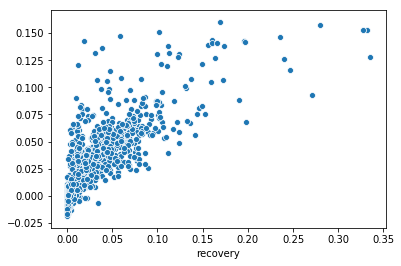

In [38]:
# Independent variables:
# X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
#           'months_active', 'lateral_len', 'ip90_boeqpd', 'county']
X_vars = ['proppant_ppf', 'gor_hist', 'gross_perfs', 'frac_fluid_gpf', 
          'months_active', 'ip90_boeqpd', 'sur_lat', 'tvd', 'sur_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

df_vert = scaled_df[scaled_df.direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[['recovery']]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
print('reg_df:')
reg_df

In [39]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
ip90_boeqpd,1.990933
gross_perfs,0.148900
months_active,0.143693
sur_long,0.029286
gor_hist,0.024755
tvd,0.014838
sur_lat,0.013922
frac_fluid_gpf,0.012422
proppant_ppf,0.007848


#### Run with features Joseph selected, with filtering for vertical wells:

MAE: 0.013838297077638957
MSE: 0.0010397808020834165
lr.intercept: 0.11211551016135615


,value
gross_perfs,0.268850
tvd,0.043224
sur_lat,0.033769
proppant_ppf,0.016660
oil_gravity,-0.021582
sur_long,-0.048919
vintage,-0.111038
frac_stages,-0.350440


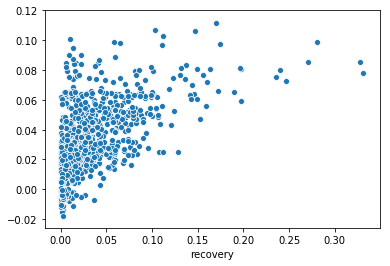

In [40]:
# Independent variables:
X_vars = ['gross_perfs', 'proppant_ppf', 'frac_stages', 'vintage', 
          'oil_gravity', 'tvd', 'sur_lat', 'sur_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

df_vert = scaled_df[scaled_df.direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[['recovery']]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [41]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
frac_stages,0.350440
gross_perfs,0.268850
vintage,0.111038
sur_long,0.048919
tvd,0.043224
sur_lat,0.033769
oil_gravity,0.021582
proppant_ppf,0.016660


# Need to add filter_columns for the following to work.

## Explore and select algorithms

In [ ]:
def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict


In [ ]:
X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
          'months_active', 'lateral_len', 'ip90_boeqpd', 'county']

lregressiontest(scaled_df, X_vars, 'recovery', .8)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering